## 模拟生成低保真数据



### 首先是PBA储存模量LF

In [1]:
import numpy as np
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from scipy.optimize import curve_fit
import itertools
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso, BayesianRidge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.font_manager as fm
%config InlineBackend.figure_format = 'svg'
# 检查系统是否安装了 Arial 字体
def is_arial_available():
    for font in fm.fontManager.ttflist:
        if 'Arial' in font.name:
            return True
    return False

# 如果系统没有 Arial 字体，加载用户自定义字体
if not is_arial_available():
    user_font_path = os.path.expanduser('~/.local/share/fonts/ARIAL.TTF')
    if os.path.exists(user_font_path):
        # 添加用户字体到 Matplotlib 的字体管理器
        fm.fontManager.addfont(user_font_path)
        # 设置 Matplotlib 使用该字体
        plt.rcParams['font.family'] = 'sans-serif'
        plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']
        print("已加载用户自定义 Arial 字体")
    else:
        print("未找到用户自定义 Arial 字体文件")
else:
    print("系统已安装 Arial 字体")
    


系统已安装 Arial 字体


Maxwell流体的频率-储存模量公式推导

Maxwell流体由一个弹簧和一个阻尼器串联组成。其本构方程为:

$\frac{1}{G}\frac{d\sigma}{dt} + \frac{\sigma}{\eta} = \frac{d\gamma}{dt}$

其中:
$\sigma$ - 应力
$\gamma$ - 应变 
$G$ - 弹性模量
$\eta$ - 粘度

在正弦振动下:
$\gamma = \gamma_0 \sin(\omega t)$
$\sigma = \sigma_0 \sin(\omega t + \delta)$

将上述表达式代入本构方程并化简,可得储存模量$G'(\omega)$:

$G'(\omega) = \frac{G\omega^2\lambda^2}{1 + \omega^2\lambda^2}$

其中$\omega$为角频率,$\lambda = \eta/G$为松弛时间


DP=40 拟合参数: G=1.10e+05, λ=8.38e-06
DP=162 拟合参数: G=4.48e+05, λ=3.43e-05
DP=274 拟合参数: G=5.93e+05, λ=6.25e-05
DP=454 拟合参数: G=5.66e+05, λ=8.95e-05
DP=611 拟合参数: G=3.45e+05, λ=1.17e-04
DP=798 拟合参数: G=6.26e+05, λ=1.04e-04
DP=1014 拟合参数: G=6.83e+05, λ=1.01e-04
DP=1184 拟合参数: G=1.14e+06, λ=5.20e-05
DP=1524 拟合参数: G=4.50e+05, λ=8.64e-04


/tmp/ipykernel_10397/2958524218.py:109: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax1.set_ylim(0, 2e7)
/tmp/ipykernel_10397/2958524218.py:110: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax2.set_ylim(0, 2e7)


数据已保存到 Data/Data_LF.xlsx


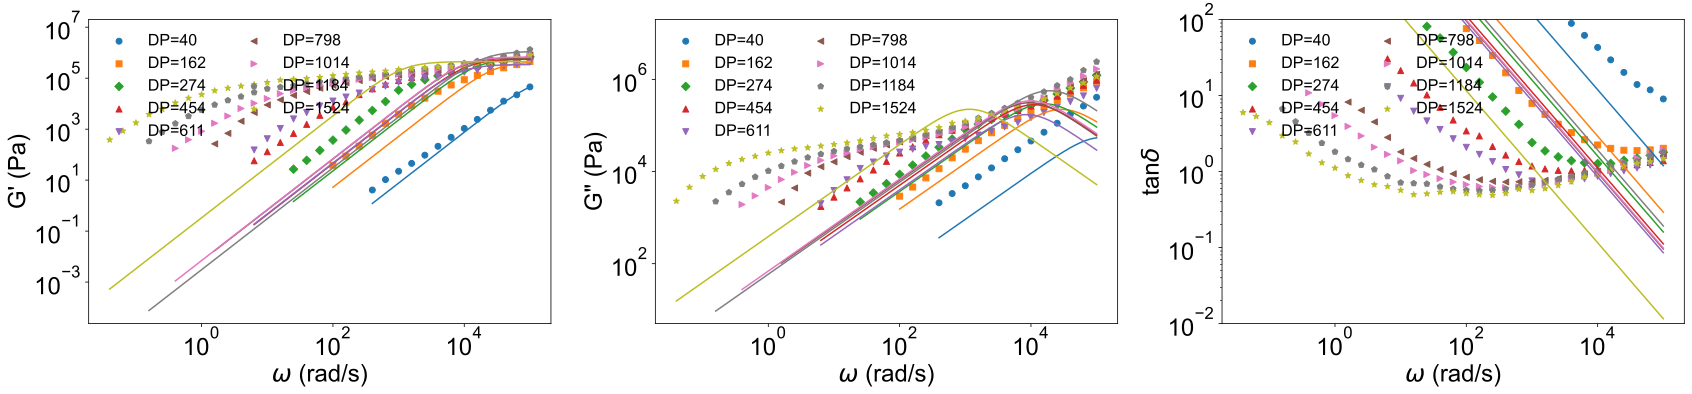

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# 魔法命令，默认生成 SVG 格式的图像
%config InlineBackend.figure_format = 'svg'
plt.rcParams['font.family'] = ['Arial']  # 设置字体为 Arial
plt.rcParams['font.size'] = 24  # 设置全局字体大小

# 定义Maxwell模型的储能模量、损耗模量和损耗因子方程
def maxwell_storage_modulus(omega, G, lambda_):
    return G * omega**2 * lambda_**2 / (1 + omega**2 * lambda_**2)

def maxwell_loss_modulus(omega, G, lambda_):
    return G * omega * lambda_ / (1 + omega**2 * lambda_**2)

def maxwell_loss_factor(omega, G, lambda_):
    return 1 / (omega * lambda_)

# 读取实验数据
url_hf = 'Data/Data_HF.xlsx'  # Excel 文件路径
df_HF = pd.read_excel(url_hf, sheet_name=None)
df_hf_sm = df_HF['Sheet1']  # 提取第一个工作表的数据

# 按照 'DP' 列进行分组
grouped = df_hf_sm.groupby('DP')

# 初始化一个空的DataFrame来存储生成的数据
generated_data = pd.DataFrame()

# 创建三个子图
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6), dpi=600)

# 定义颜色和标记样式
colors = plt.cm.tab10.colors  # 使用 tab10 颜色映射
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h']  # 定义不同的标记样式

# 对每一组数据进行拟合
for i, (dp, group) in enumerate(grouped):
    # 提取实验数据
    omega = group['AngFreq'].values
    G_storage = group['StorageM'].values
    G_loss = group['LossM'].values
    loss_factor = group['lossF'].values
    
    try:
        # 使用curve_fit进行非线性拟合
        p0 = [max(G_storage), 1/np.mean(omega)]
        bounds = ([0, 0], [np.inf, np.inf])
        
        popt, _ = curve_fit(maxwell_storage_modulus, omega, G_storage, p0=p0, bounds=bounds)
        
        # 生成新的频率点（原始数据的10倍点数）
        n_points = len(omega) * 10
        omega_new = np.logspace(np.log10(min(omega)), np.log10(max(omega)), n_points)
        G_storage_new = maxwell_storage_modulus(omega_new, *popt)
        G_loss_new = maxwell_loss_modulus(omega_new, *popt)
        loss_factor_new = maxwell_loss_factor(omega_new, *popt)
        
        # 创建新的DataFrame
        df_new = pd.DataFrame({
            'DP': [dp] * n_points,
            'AngFreq': omega_new,
            'StorageM': G_storage_new,
            'LossM': G_loss_new,
            'lossF': loss_factor_new,
            'Mn': [group['Mn'].iloc[0]] * n_points,
            'PDI': [group['PDI'].iloc[0]] * n_points
        })
        
        # 将新生成的数据添加到总DataFrame中
        generated_data = pd.concat([generated_data, df_new], ignore_index=True)
        
        # 绘制拟合曲线和实验数据点
        # 储存模量
        ax1.plot(omega_new, G_storage_new, color=colors[i % len(colors)])
        ax1.scatter(omega, G_storage, color=colors[i % len(colors)],
                   marker=markers[i % len(markers)], label=f'DP={dp}')
        
        # 损耗模量
        ax2.plot(omega_new, G_loss_new, color=colors[i % len(colors)])
        ax2.scatter(omega, G_loss, color=colors[i % len(colors)],
                   marker=markers[i % len(markers)], label=f'DP={dp}')
        
        # 损耗因子
        ax3.plot(omega_new, loss_factor_new, color=colors[i % len(colors)])
        ax3.scatter(omega, loss_factor, color=colors[i % len(colors)],
                   marker=markers[i % len(markers)], label=f'DP={dp}')
        
        print(f"DP={dp} 拟合参数: G={popt[0]:.2e}, λ={popt[1]:.2e}")
        
    except Exception as e:
        print(f"DP={dp} 拟合失败: {str(e)}")

# 设置图形属性
for ax in [ax1, ax2, ax3]:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend(ncol=2, fontsize=16, loc='upper left', frameon=False)
    ax.set_xlabel('$\omega$ (rad/s)')

# 设置y轴标签
ax1.set_ylabel('G\' (Pa)')
ax2.set_ylabel('G\" (Pa)')
ax3.set_ylabel('tan$\\delta$')

# 设置y轴范围
ax1.set_ylim(0, 2e7)
ax2.set_ylim(0, 2e7)
ax3.set_ylim(0.01, 100)

# 调整布局
plt.tight_layout()

# 保存生成的数据到Excel文件
output_path = 'Data/Data_LF.xlsx'
generated_data.to_excel(output_path, index=False)
print(f"数据已保存到 {output_path}")

# 显示图形
plt.show()

- PFGs LF 


DP=40 拟合参数:
G1=5.75e+04 Pa
G2=7.87e+05 Pa
τ1=7.63e-03 s
G3=3.74e+04 Pa
τ2=1.00e-04 s

DP=162 拟合参数:
G1=5.11e+04 Pa
G2=7.31e+05 Pa
τ1=5.15e-03 s
G3=1.18e+04 Pa
τ2=1.00e-04 s

DP=274 拟合参数:
G1=6.09e+04 Pa
G2=6.67e+05 Pa
τ1=7.48e-03 s
G3=8.77e+03 Pa
τ2=1.00e-04 s

DP=454 拟合参数:
G1=6.40e+04 Pa
G2=5.82e+05 Pa
τ1=1.52e-02 s
G3=7.44e+03 Pa
τ2=1.00e-04 s

DP=611 拟合参数:
G1=5.59e+04 Pa
G2=4.61e+05 Pa
τ1=1.33e-01 s
G3=5.03e+03 Pa
τ2=1.00e-04 s

DP=798 拟合参数:
G1=5.60e+04 Pa
G2=5.28e+05 Pa
τ1=2.40e-01 s
G3=5.40e+03 Pa
τ2=1.00e-04 s

DP=1014 拟合参数:
G1=9.12e+04 Pa
G2=6.68e+05 Pa
τ1=4.64e-01 s
G3=1.02e+04 Pa
τ2=1.00e-04 s

DP=1184 拟合参数:
G1=9.51e+04 Pa
G2=6.19e+05 Pa
τ1=8.61e-01 s
G3=1.23e+04 Pa
τ2=1.00e-04 s

DP=1524 拟合参数:
G1=1.18e+05 Pa
G2=7.88e+05 Pa
τ1=1.69e+00 s
G3=1.83e+04 Pa
τ2=1.00e-04 s
数据已保存到 Data/Data_LF_S_PFGs.xlsx


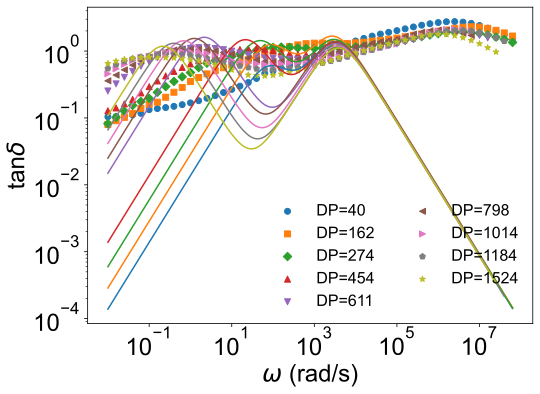

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# 魔法命令，默认生成 SVG 格式的图像
%config InlineBackend.figure_format = 'svg'
plt.rcParams['font.family'] = ['Arial']  # 设置字体为 Arial
plt.rcParams['font.size'] = 24  # 设置全局字体大小

# 定义双Maxwell模型的损耗因子函数
def double_maxwell_loss_factor(omega, G1, G2, tau1, G3, tau2):
    """
    双Maxwell模型的损耗因子
    G1: 第一个Maxwell单元的弹性模量
    G2: 第二个Maxwell单元的弹性模量
    tau1: 第一个Maxwell单元的松弛时间
    G3: 第三个Maxwell单元的弹性模量
    tau2: 第二个Maxwell单元的松弛时间
    """
    G_prime = (G1 * (omega*tau1)**2)/(1 + (omega*tau1)**2) + \
              (G2 * (omega*tau2)**2)/(1 + (omega*tau2)**2) + G3
              
    G_double_prime = (G1 * omega*tau1)/(1 + (omega*tau1)**2) + \
                     (G2 * omega*tau2)/(1 + (omega*tau2)**2)
                     
    return G_double_prime/G_prime

# 基于数据特征生成初始参数
def get_initial_params(omega, loss_factor):
    G1_guess = 1e5  
    G2_guess = 1e4  
    tau1_guess = 0.1  
    G3_guess = 1e4  
    tau2_guess = 0.01  
    return [G1_guess, G2_guess, tau1_guess, G3_guess, tau2_guess]

# 读取实验数据
url_hf = 'Data/Data_HF.xlsx'  
df_HF = pd.read_excel(url_hf, sheet_name=None)
df_hf_sm = df_HF['Sheet2']  

# 按照 'DP' 列进行分组
grouped = df_hf_sm.groupby('DP')

# 初始化一个空的DataFrame来存储生成的数据
generated_data = pd.DataFrame()

# 创建图形和轴对象
fig, ax = plt.subplots(figsize=(8, 6), dpi=600)

# 定义颜色和标记样式
colors = plt.cm.tab10.colors  
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h']  

# 设置物理意义的参数边界
bounds_lower = [1e3, 1e2, 1e-3, 1e2, 1e-4]   # G1_min, G2_min, τ1_min, G3_min, τ2_min
bounds_upper = [1e7, 1e6, 10, 1e6, 1]      # G1_max, G2_max, τ1_max, G3_max, τ2_max

# 对每一组进行全局拟合
for i, (dp, group) in enumerate(grouped):
    # 提取实验数据
    omega = group['AngFreq'].values
    loss_factor = group['LossFactor'].values

    try:
        # 获取初始参数
        p0 = get_initial_params(omega, loss_factor)
        
        # 设置参数边界
        bounds = (bounds_lower, bounds_upper)
        
        # 拟合双Maxwell模型
        popt, pcov = curve_fit(double_maxwell_loss_factor, omega, loss_factor, 
                             p0=p0, bounds=bounds, maxfev=5000, method='trf')
        
        # 生成新的频率点用于绘制平滑曲线
        n_points = len(omega) * 10
        omega_new = np.logspace(np.log10(min(omega)), np.log10(max(omega)), n_points)
        
        # 计算拟合曲线
        loss_factor_new = double_maxwell_loss_factor(omega_new, *popt)

        # 创建新的DataFrame
        df_new = pd.DataFrame({
            'DP': [dp] * n_points,
            'AngFreq': omega_new,
            'LossFactor': loss_factor_new,
            'Mn': [group['Mn'].iloc[0]] * n_points,
            'PDI': [group['PDI'].iloc[0]] * n_points
        })
        
        # 将新生成的数据添加到总DataFrame中
        generated_data = pd.concat([generated_data, df_new], ignore_index=True)

        # 绘制拟合曲线和实验数据点
        ax.plot(omega_new, loss_factor_new, color=colors[i % len(colors)])
        ax.scatter(omega, loss_factor, color=colors[i % len(colors)],
                  marker=markers[i % len(markers)], label=f'DP={dp}')

        # 打印拟合参数
        print(f"\nDP={dp} 拟合参数:")
        print(f"G1={popt[0]:.2e} Pa")
        print(f"G2={popt[1]:.2e} Pa")
        print(f"τ1={popt[2]:.2e} s")
        print(f"G3={popt[3]:.2e} Pa")
        print(f"τ2={popt[4]:.2e} s")
        
    except Exception as e:
        print(f"DP={dp} 拟合失败: {str(e)}")

# 设置图形属性
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(ncol=2, fontsize=16, loc='lower right', frameon=False)
ax.set_xlabel('$\omega$ (rad/s)')
ax.set_ylabel('tan$\\delta$')

# 调整布局
plt.tight_layout()

# 保存生成的数据到Excel文件
output_path = 'Data/Data_LF_S_PFGs.xlsx'
generated_data.to_excel(output_path, index=False)
print(f"数据已保存到 {output_path}")

# 显示图形
plt.show()


- PFGs com


PFG-b1 拟合参数:
G1=1.03e+03 Pa
τ1=2.88e-02 s
G2=1.00e+02 Pa
β=1.00e-01
α=8.85e-01

PFG-b2 拟合参数:
G1=1.00e+03 Pa
τ1=5.06e-02 s
G2=1.41e+02 Pa
β=1.00e-01
α=8.73e-01

PFG-b3 拟合参数:
G1=1.00e+03 Pa
τ1=5.05e-02 s
G2=1.31e+02 Pa
β=1.00e-01
α=7.55e-01

PFG-b4 拟合参数:
G1=1.00e+03 Pa
τ1=5.07e-02 s
G2=1.05e+02 Pa
β=1.00e-01
α=8.71e-01

PFG-b5 拟合参数:
G1=1.00e+03 Pa
τ1=1.54e-01 s
G2=1.17e+02 Pa
β=1.00e-01
α=7.07e-01

PFG-b6 拟合参数:
G1=1.00e+03 Pa
τ1=4.09e-01 s
G2=1.06e+02 Pa
β=1.00e-01
α=7.06e-01
数据已保存到 Data/Data_LF_PFGs.xlsx


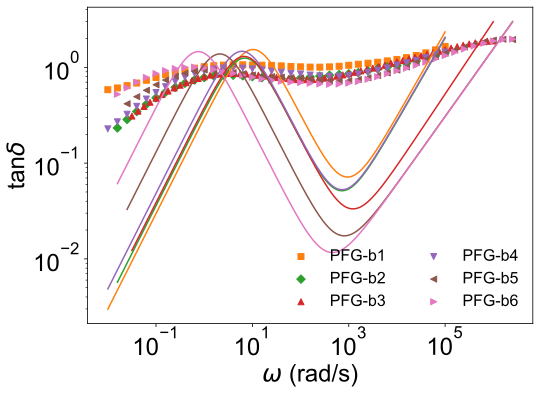

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# 魔法命令，默认生成 SVG 格式的图像
%config InlineBackend.figure_format = 'svg'
plt.rcParams['font.family'] = ['Arial']  # 设置字体为 Arial
plt.rcParams['font.size'] = 24  # 设置全局字体大小

# 修改模型为单Maxwell模型加上连续松弛谱
def modified_maxwell_loss_factor(omega, G1, tau1, G2, beta, alpha):
    """
    修改后的模型:单Maxwell模型加上连续松弛谱
    G1: Maxwell单元的弹性模量
    tau1: Maxwell单元的松弛时间
    G2: 基础弹性模量
    beta: 松弛谱强度参数
    alpha: 松弛谱指数参数
    """
    # Maxwell项
    G_prime = (G1 * (omega*tau1)**2)/(1 + (omega*tau1)**2) + G2
    G_double_prime = (G1 * omega*tau1)/(1 + (omega*tau1)**2)
    
    # 添加连续松弛谱项，确保高频区域单调增长
    G_double_prime += beta * omega**alpha
    
    return G_double_prime/(G_prime + 1e-10)

# 基于数据特征生成初始参数
def get_initial_params(omega, loss_factor):
    G1_guess = 1e5
    tau1_guess = 0.1
    G2_guess = 1e4
    beta_guess = 1e-2
    alpha_guess = 0.5  # 松弛谱指数，控制高频增长率
    return [G1_guess, tau1_guess, G2_guess, beta_guess, alpha_guess]

# 读取实验数据
url_hf = 'Data/DifferComponent_data.xlsm'  
df_HF = pd.read_excel(url_hf, sheet_name=None)
filtered_sheets = {name: df for name, df in df_HF.items() if name.lower() != 's'}

# 合并所有工作表并添加标识列
combined_df = pd.concat(
    [df.assign(sheet_name=name) for name, df in filtered_sheets.items()],
    ignore_index=True
)

# 按工作表名称分组
grouped = combined_df.groupby('sheet_name')

# 初始化一个空的DataFrame来存储生成的数据
generated_data = pd.DataFrame()

# 创建图形和轴对象
fig, ax = plt.subplots(figsize=(8, 6), dpi=600)

# 定义颜色和标记样式
colors = plt.cm.tab10.colors  
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h']  

# 设置物理意义的参数边界
bounds_lower = [1e3, 1e-3, 1e2, 1e-4, 0.1]    # G1_min, τ1_min, G2_min, beta_min, alpha_min
bounds_upper = [1e7, 10, 1e6, 1e-1, 1.0]      # G1_max, τ1_max, G2_max, beta_max, alpha_max

idx = 0
# 对每一组进行全局拟合
for name, group in grouped:
    idx += 1
    # 提取实验数据
    omega = group['AngFreq'].values
    loss_factor = group['lossF'].values

    try:
        # 获取初始参数
        p0 = get_initial_params(omega, loss_factor)
        
        # 设置参数边界
        bounds = (bounds_lower, bounds_upper)
        
        # 拟合修改后的模型
        popt, pcov = curve_fit(modified_maxwell_loss_factor, omega, loss_factor, 
                             p0=p0, bounds=bounds, maxfev=10000, method='trf')
        
        # 生成新的频率点用于绘制平滑曲线
        n_points = len(omega) * 10
        omega_new = np.logspace(np.log10(min(omega)), np.log10(max(omega)), n_points)
        
        # 计算拟合曲线
        loss_factor_new = modified_maxwell_loss_factor(omega_new, *popt)

        # 创建新的DataFrame
        df_new = pd.DataFrame({
            'sheet_name': [name] * n_points,
            'AngFreq': omega_new,
            'lossF': loss_factor_new,
            'Mn1': [group['Mn1'].iloc[0]] * n_points,
            'Mn2': [group['Mn2'].iloc[0]] * n_points,
            'Mn3': [group['Mn3'].iloc[0]] * n_points,
            'Mn11': [group['Mn11'].iloc[0]] * n_points,
            'Mn22': [group['Mn22'].iloc[0]] * n_points,
            'Mn33': [group['Mn33'].iloc[0]] * n_points
        })
        
        # 将新生成的数据添加到总DataFrame中
        generated_data = pd.concat([generated_data, df_new], ignore_index=True)

        # 绘制拟合曲线和实验数据点
        ax.plot(omega_new, loss_factor_new, color=colors[idx % len(colors)])
        ax.scatter(omega, loss_factor, color=colors[idx % len(colors)],
                  marker=markers[idx % len(markers)], label=f'PFG-b{idx}')

        # 打印拟合参数
        print(f"\nPFG-b{idx} 拟合参数:")
        print(f"G1={popt[0]:.2e} Pa")
        print(f"τ1={popt[1]:.2e} s")
        print(f"G2={popt[2]:.2e} Pa")
        print(f"β={popt[3]:.2e}")
        print(f"α={popt[4]:.2e}")
        
    except Exception as e:
        print(f"PFG-b{idx} 拟合失败: {str(e)}")

# 设置图形属性
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(ncol=2, fontsize=16, loc='lower right', frameon=False)
ax.set_xlabel('$\omega$ (rad/s)')
ax.set_ylabel('tan$\\delta$')

# 调整布局
plt.tight_layout()

# 保存生成的数据到Excel文件
output_path = 'Data/Data_LF_PFGs.xlsx'
generated_data.to_excel(output_path, index=False)
print(f"数据已保存到 {output_path}")

# 显示图形
plt.show()
